In [83]:
import pandas as pd

# Create a DataFrame
data = pd.read_csv('./data/cleaned_data.csv')
df = pd.DataFrame(data=data)

# Display the first few rows of the DataFrame
df.head()

,SampleID,Actinobacteria,Bacteroides,Bacteroidetes,Bifidobacterium,Clostridium,Cyanobacteria,Firmicutes,Fusobacteria,Lactobacillus,Other,Prevotella,Proteobacteria,Tenericutes,Verrucomicrobia,Fiber_intake_g,Fat_intake_g,Iron_intake_mg,Serum_iron_ug
0,000007117.1075649,0.3244,0.0013,0.0315,0.0000,0.0013,0.0352,0.2629,0.0082,0.0027,0.0461,0.0028,0.2821,0.0010,0.0005,20.37,81.73,13.50,80.03
1,000007115.1075661,0.0347,0.0087,0.1735,0.0018,0.0149,0.0289,0.1783,0.0032,0.0166,0.0153,0.0025,0.5196,0.0000,0.0020,18.69,59.38,19.44,77.60
2,000007123.1075697,0.0493,0.0000,0.0153,0.0000,0.0002,0.1265,0.0451,0.0025,0.1222,0.0024,0.0007,0.6347,0.0000,0.0011,20.27,62.60,19.03,122.20
3,000009713.1130401,0.4052,0.0010,0.0091,0.0000,0.0002,0.0265,0.4219,0.0026,0.0015,0.0055,0.0062,0.1191,0.0000,0.0012,0.20,105.56,16.23,93.48
4,000005598.1130569,0.2394,0.0072,0.0401,0.0001,0.0010,0.0255,0.2582,0.0013,0.0170,0.0209,0.0024,0.3828,0.0003,0.0038,16.00,96.82,14.17,70.19


In [ ]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
import numpy as np

target_column = 'Serum_iron_ug'

# Features and target
X = df.drop(columns=[target_column, "SampleID"])
y = df[target_column]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
coef_list = []

scoring = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': make_scorer(mean_absolute_error)
}

# Train on each fold and store coefficients
for train_idx, test_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Fit scaler on training fold
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = BayesianRidge()
    model.fit(X_train_scaled, y_train)
   
    coef_list.append(model.coef_)

# Create a pipeline: scaling + Bayesian Ridge
pipeline = make_pipeline(StandardScaler(), BayesianRidge())

# Cross-validation on the whole data
cv_results = cross_validate(
    pipeline, X, y, cv=kf,
    scoring=scoring, return_train_score=True
)

print("Mean R²:", np.mean(cv_results['test_R2']))
print("Mean MSE:", -np.mean(cv_results['test_MSE']))  # negate because sklearn returns negative MSE
print("Mean MAE:", np.mean(cv_results['test_MAE']))

# Convert to DataFrame
coef_array = np.array(coef_list)
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean_Coefficient": coef_array.mean(axis=0),
    "Std_Coefficient": coef_array.std(axis=0)
}).sort_values(by="Mean_Coefficient", key=abs, ascending=False)


Mean R²: 0.6199192931622666
Mean MSE: 538.7338806828429
Mean MAE: 18.456359867013084


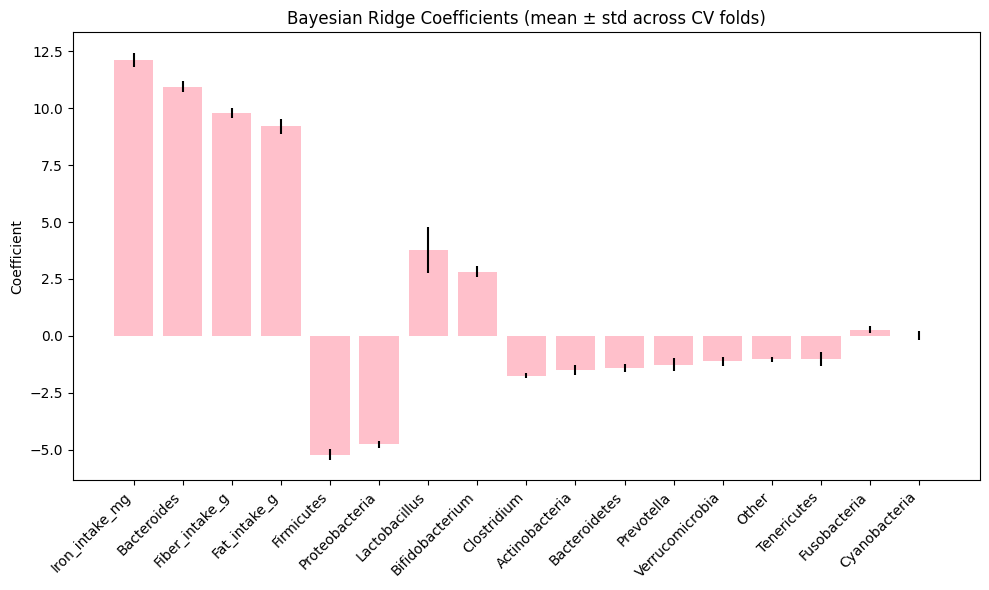

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(coef_df['Feature'], coef_df['Mean_Coefficient'], yerr=coef_df['Std_Coefficient'], color='pink')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Coefficient')
plt.title('Bayesian Ridge Coefficients (mean ± std across CV folds)')
plt.tight_layout()
plt.show()

Here we can see the mean coefficents for each feature across cross validation folds. The black lines represent the standard deviation.

We can see that dietary intake all have a positive influence on serum iron, along with presence of Bacteroides, and all are relatively stable across folds. Likewise Firmicutes and Proteobacteria both have a negative influence.

Meanwhile Lactobacillus and Bifidobacterium both have a small positive impact, as expected. Lactobacillus has the largest standard deviation across the cross validation folds, which can be explained by the fact that it is not present in all the samples and yet plays a substantial role in the simulated serum iron.

In [86]:
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

target_column = 'Serum_iron_ug'

X = df.drop(columns=[target_column, "SampleID"])
y = df[target_column]

# Permute the target for negative control
y_permuted = np.random.permutation(y)

# CV setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline to avoid data leakage
pipeline = make_pipeline(StandardScaler(), BayesianRidge())

scoring = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': make_scorer(mean_absolute_error)
}

perm_cv_results = cross_validate(pipeline, X, y_permuted, cv=kf, scoring=scoring)

print("Permuted Mean R²:", np.mean(perm_cv_results['test_R2']))
print("Permuted Mean MSE:", -np.mean(perm_cv_results['test_MSE']))
print("Permuted Mean MAE:", np.mean(perm_cv_results['test_MAE']))


Permuted Mean R²: -0.005256300994258956
Permuted Mean MSE: 1424.2854800256962
Permuted Mean MAE: 29.853379565196622


The results here look as we would hope for, with $R^2$ close to zero and slightly negative and more than double the Mean Squared Error. MAE is also much worse than on the real data. These all show us that there is no overfitting to random noise and the model's performance is based on actual signal.

In [ ]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Number of bootstrap samples
B = 500  

r2_scores = []
mse_scores = []
mae_scores = []
coef_samples = []

n = len(df)

model = BayesianRidge()

for i in range(B):
    # Sample indices WITH replacement
    sample_idx = np.random.choice(n, size=n, replace=True)
    
    X_sample = X.iloc[sample_idx]
    y_sample = y.iloc[sample_idx]
    
    # Scale the features
    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample)

    # Fit and predict
    model.fit(X_sample_scaled, y_sample)
    y_pred = model.predict(X_sample_scaled)
    
    # Store metrics
    r2_scores.append(r2_score(y_sample, y_pred))
    mse_scores.append(mean_squared_error(y_sample, y_pred))
    mae_scores.append(mean_absolute_error(y_sample, y_pred))
    coef_samples.append(model.coef_)

# Compute 95% confidence intervals
def ci(arr):
    return np.percentile(arr, [2.5, 97.5])

r2_ci = ci(r2_scores)
mse_ci = ci(mse_scores)
mae_ci = ci(mae_scores)

print("Bootstrapped R² 95% CI:", r2_ci)
print("Bootstrapped MSE 95% CI:", mse_ci)
print("Bootstrapped MAE 95% CI:", mae_ci)

coef_samples = np.array(coef_samples)

coef_mean = coef_samples.mean(axis=0)
coef_std = coef_samples.std(axis=0)
coef_ci_lower = np.percentile(coef_samples, 2.5, axis=0)
coef_ci_upper = np.percentile(coef_samples, 97.5, axis=0)

coef_boot_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean_Coefficient": coef_mean,
    "Std_Coefficient": coef_std,
    "CI_lower": coef_ci_lower,
    "CI_upper": coef_ci_upper
}).sort_values(by="Mean_Coefficient", key=abs, ascending=False)

coef_boot_df

Bootstrapped R² 95% CI: [0.60042425 0.64962336]
Bootstrapped MSE 95% CI: [501.6556438  560.25155099]
Bootstrapped MAE 95% CI: [17.78600976 18.85392094]


,Feature,Mean_Coefficient,Std_Coefficient,CI_lower,CI_upper
16,Iron_intake_mg,12.122282,0.630100,10.917502,13.224580
1,Bacteroides,10.934223,0.549217,9.800921,11.975024
14,Fiber_intake_g,9.827378,0.510331,8.781204,10.799828
15,Fat_intake_g,9.210833,0.546606,8.186079,10.330488
6,Firmicutes,-5.199909,0.502494,-6.167571,-4.156533
11,Proteobacteria,-4.755465,0.412779,-5.583887,-4.009976
8,Lactobacillus,3.625236,1.423496,1.165765,6.229797
3,Bifidobacterium,2.803792,0.531545,1.740405,3.824439
4,Clostridium,-1.747123,0.527512,-2.755000,-0.749318
0,Actinobacteria,-1.495611,0.462122,-2.369671,-0.557115


Our confidence interval is narrow, showing that model performance is stable. We can also see that there is strong predictive signal and the results are consistent with our cross validation $R^2$ (~0.62). The model reliably explains ~60-65% of variance in serum iron, even across resampled datasets.